In [1]:
import wrf
import cartopy.crs as ccrs
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyart
import zipfile
import datetime as dt
import os
import tqdm
import pandas as pd
import warnings
from metpy.interpolate import cross_section

warnings.simplefilter("ignore")

def plot_radar(rid, time, lon, lat, ax, sweep=1, plot_cbar=False, cax=[0.2,0.08,0.6,0.01]):
    
    radar = load_radar(rid, time)
    disp=pyart.graph.GridMapDisplay(radar)
    if rid=="2":
        min_lon=143; max_lon=146; min_lat=-39.5; max_lat=-36.5
    if rid=="68":
        min_lon=145; max_lon=148; min_lat=-39.5; max_lat=-36.5        
    elif rid=="40":
        min_lon=147; max_lon=151; min_lat=-36.5; max_lat=-33.5
    elif rid=="71":
        min_lon=149; max_lon=152; min_lat=-35; max_lat=-32
    elif rid=="56":
        min_lon=142; max_lon=145; min_lat=-24; max_lat=-21
    elif rid=="8":
        min_lon=151; max_lon=154; min_lat=-27.5; max_lat=-24.5
    elif rid=="50":
        min_lon=151; max_lon=154; min_lat=-29; max_lat=-26
    elif rid=="66":
        min_lon=150; max_lon=155; min_lat=-29; max_lat=-25
    x,y = radar.get_point_longitude_latitude()
    c=ax.pcolormesh(x, y, np.nanmax(radar.fields["corrected_reflectivity"]["data"],axis=0),
                   cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin=0, vmax=60)
    ax.set_ylim([min_lat, max_lat])
    ax.set_xlim([min_lon, max_lon])
    ax.plot(lon, lat, marker="x", mew=2, ms=12, color="k")
    if plot_cbar:
        cb=plt.colorbar(c, cax=plt.axes(cax), orientation="horizontal", extend="both")
        cb.set_label("Reflectivity (DBZ)")
    return disp
    
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60*6), time]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    radar_file = pyart.io.read_grid(target_files[0])
    
    _ = [os.remove(f) for f in target_files]
    
    return radar_file 

def load_radar_range(rid, times):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    out = []
    time_out = []
    for f in tqdm.tqdm(target_files):
            radar_file = pyart.io.read_grid(f).to_xarray().corrected_reflectivity.isel({"time":0}).max("z")
            out.append(radar_file.values)
            time_out.append(radar_file.time.values)
    
    _ = [os.remove(f) for f in target_files]
    
    return out, time_out, radar_file.lon.values, radar_file.lat.values


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#Load the WRF simulation output. Currently, the standard wrfout files are hourly, whereas the highres files are 10-minute, but only contain surface winds
wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/wrfout*d03*"))]
wrflist_d02 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/wrfout*d02*"))]
wrflist_d03 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/wrfout*d01*"))]
wrflist_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/highres*d03*"))]
wrflist_d02_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/highres*d02*"))]
wrflist_d03_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/highres*d01*"))]

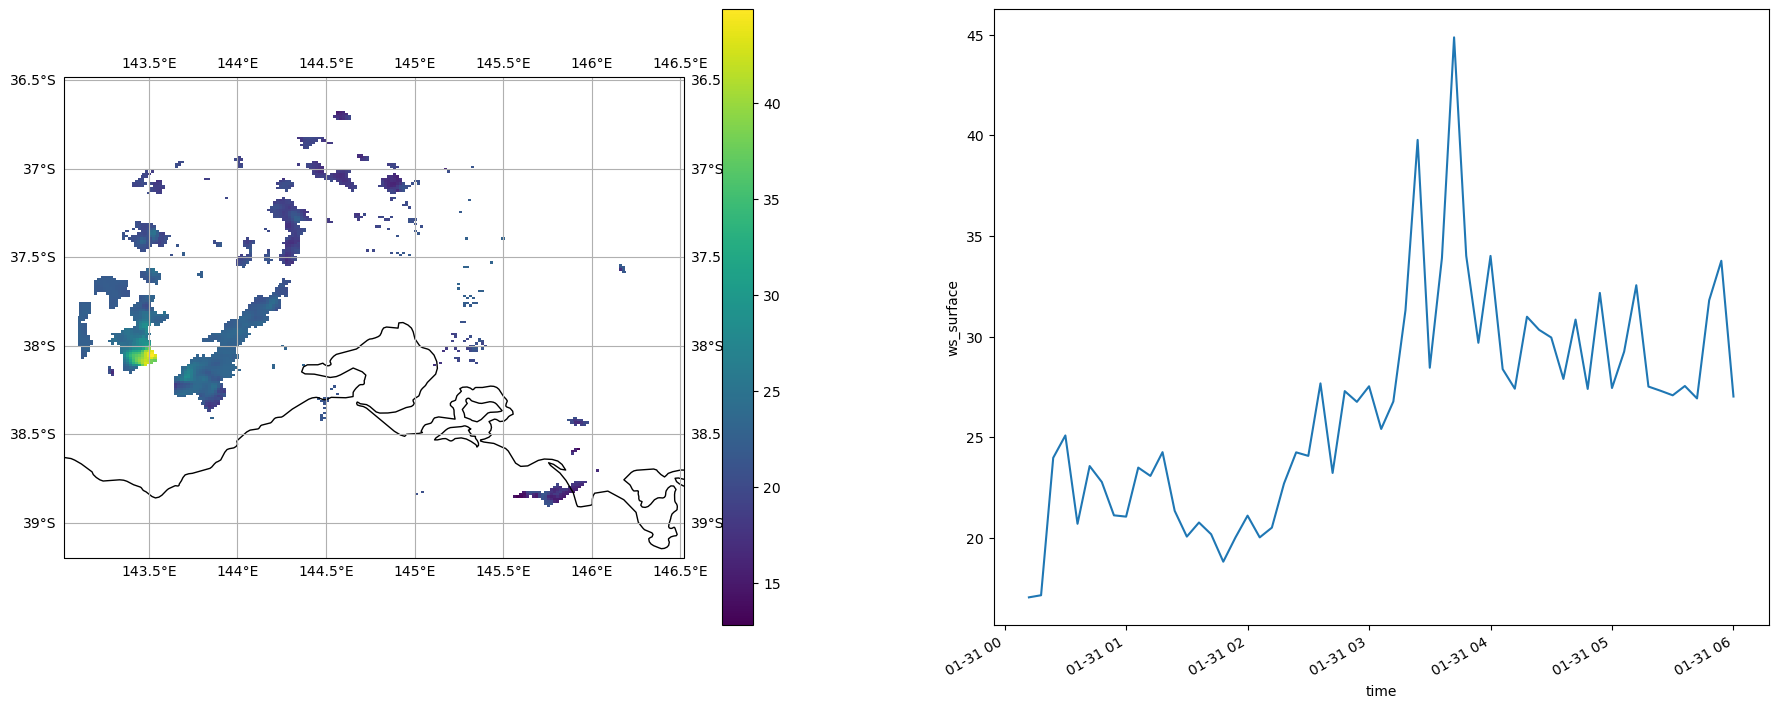

In [3]:
#Have a look at Alain's wind retrievals

def preprocess(ds):
    ds = ds.expand_dims({"time":[dt.datetime.strptime(ds.attrs["date"],"%Y-%m-%dT%H:%M:%S")]})
    ds = ds.assign({"ws_surface":np.sqrt((np.square(ds.vx_surface) + np.square(ds.vy_surface)))})
    ds = ds.assign({"ws":np.sqrt((np.square(ds.vx) + np.square(ds.vy)))})
    return ds

rad_wnd = xr.open_mfdataset("/g/data/eg3/ab4502/Andrew_retrievals/20200131/2_20200131_*.nc",preprocess=preprocess)

plt.figure(figsize=[22,8])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())

lat=rad_wnd.isel({"time":0}).latitude.values
lon=rad_wnd.isel({"time":0}).longitude.values
c=ax.pcolormesh(lon,lat,rad_wnd.ws_surface.sel({"time":"2020-01-31 03:42"}).values)
ax.gridlines(draw_labels=True)
ax.coastlines()
plt.colorbar(c)

ax=plt.subplot(1,2,2)
rad_wnd.ws_surface.max(("x","y")).plot()

In [4]:
#From the highres WRF data, get the wind speed
U10E = np.vstack([f["U10E"][:] for f in wrflist_hr])
V10E = np.vstack([f["V10E"][:] for f in wrflist_hr])
speed = np.sqrt(U10E**2+V10E**2)
times = wrf.extract_times(wrflist_hr,wrf.ALL_TIMES)

In [5]:
#Load AWS data for this event (loading the whole year is most convenient, but takes a while)
aws = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/vic_one_min_gust/2020.csv")

<AxesSubplot:xlabel='dt_utc', ylabel='ws_surface'>

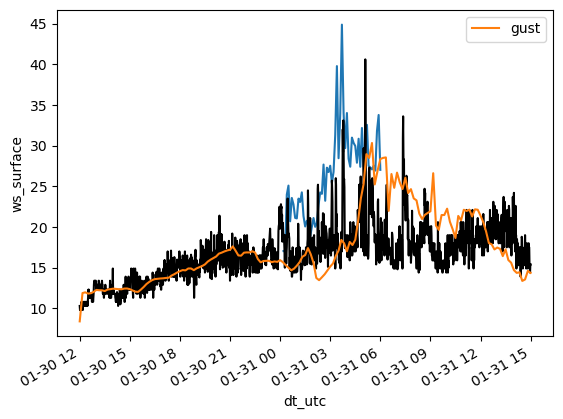

In [6]:
#Compare the state-wide maximum AWS gust time series with the domain-maximum WRF wind
aws = aws.set_index(pd.DatetimeIndex(aws.dt_utc))
ax=plt.axes()
rad_wnd.ws_surface.max(("x","y")).plot(ax=ax,color="tab:blue")
aws.loc[slice("2020-01-30 12:00","2020-01-31 15:00")].groupby(level=0).max().gust.plot(ax=ax,color="k")
pd.DataFrame({"gust":np.max(speed,axis=(1,2))}, index=times).plot(color="tab:orange",ax=ax)


In [7]:
#Get the observed radar data from t0 for a number of hours, taking the column max

hourly_times = []
t0=dt.datetime(2020,1,31,3)
hours=8
for t in np.arange(hours):
    t_temp = t0 + dt.timedelta(hours=float(t))
    print(t_temp)
    hourly_times.append(t_temp)

a, b, lon, lat =load_radar_range("2",[t0+ dt.timedelta(hours=-1),hourly_times[-1]])

a=np.stack(a)
b=np.stack(b)

hourly_radar = []
for t_temp in hourly_times:
    hourly_radar.append(np.nanmax(a[(b> (t_temp+dt.timedelta(hours=-1))) & (b<t_temp)],axis=0))

2020-01-31 03:00:00
2020-01-31 04:00:00
2020-01-31 05:00:00
2020-01-31 06:00:00
2020-01-31 07:00:00
2020-01-31 08:00:00
2020-01-31 09:00:00
2020-01-31 10:00:00


100%|██████████| 80/80 [00:19<00:00,  4.03it/s]


In [8]:
def plot(file_list,v,t_ind,ax,levels=None,cmap=None,lev=None):
    
    #Code to plot lat-lon contours of various quantities
    
    if v == "REFL_10CM":
        p1 = wrf.getvar(file_list, v, timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}).max("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    elif v == "THETA":
        p1 = wrf.getvar(file_list, "theta", timeidx=t_ind, method="cat")
        time=p1.Time.values
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)      
    elif v == "THETA-E":
        p1 = wrf.getvar(file_list, "theta_e", timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)              
    elif v == "W_MIN":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        p1 = xr.where(heights < 3000, p1, np.nan)
        c=xr.plot.contourf(p1.min("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)        
    elif v == "W":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind, method="cat")
        time=p1.Time.values
        p1 = wrf.interplevel(p1,heights,lev)
        c=xr.plot.contourf(p1,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)                
    elif v == "WS10":
        p1 = wrf.getvar(file_list, "U10E", timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        p2 = wrf.getvar(file_list, "V10E", timeidx=wrf.ALL_TIMES, method="cat")
        p=np.sqrt(p1**2+p2**2)
        p.attrs=p1.attrs
        c=xr.plot.contourf(p.isel({"Time":t_ind}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    else:
        p1 = wrf.getvar(file_list, v, timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    plt.title(time)
        

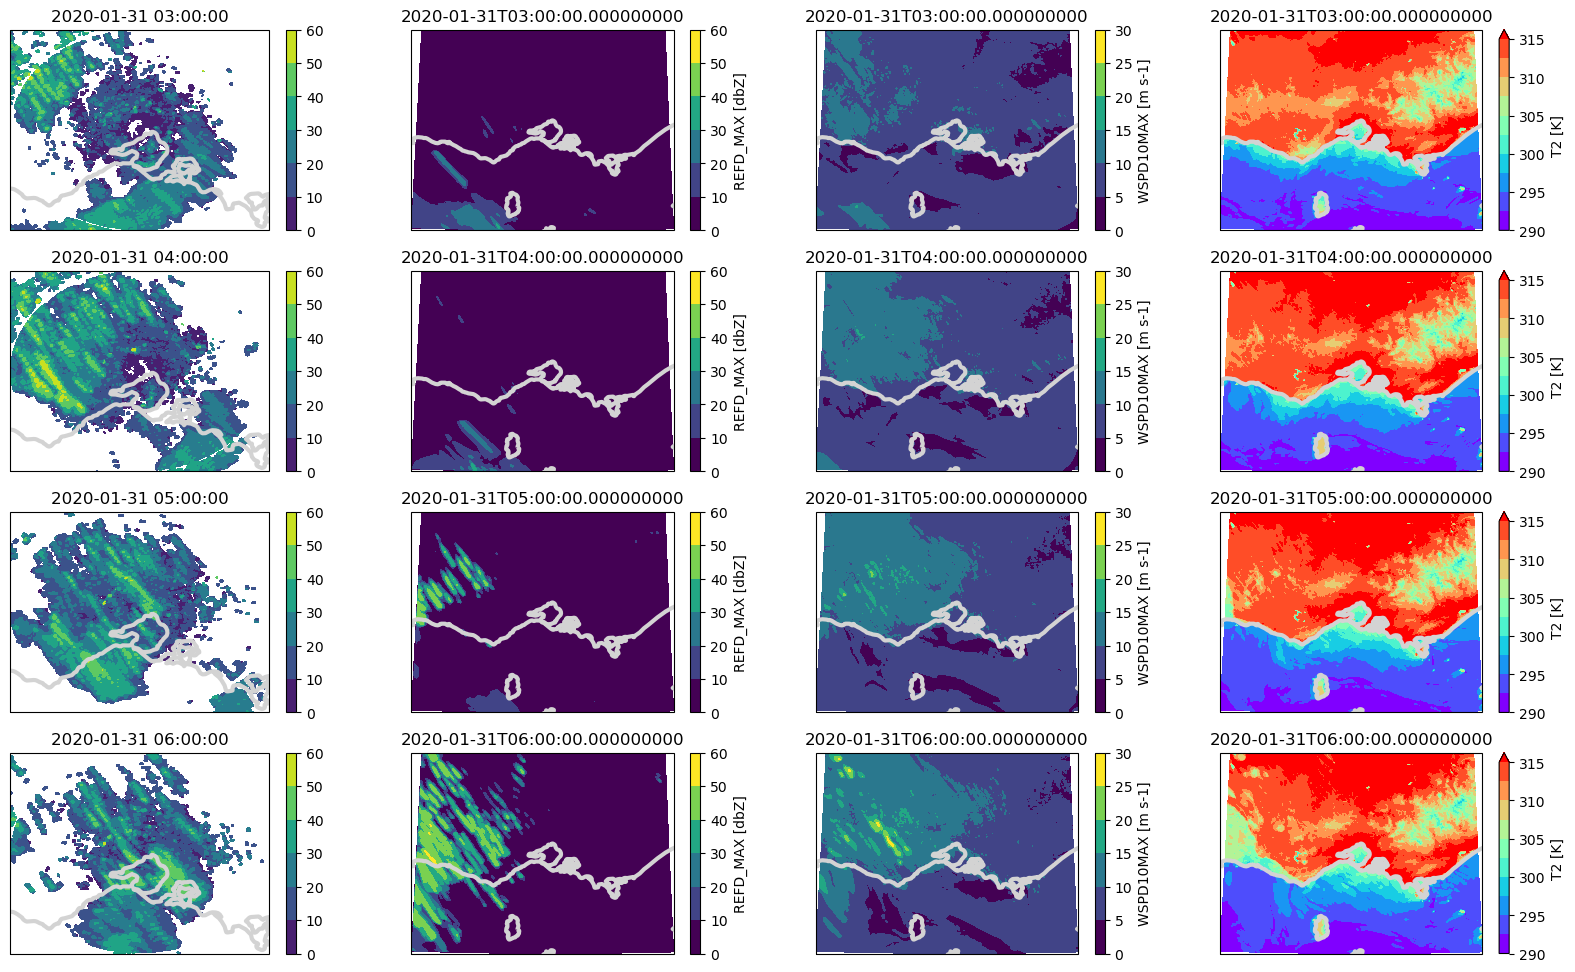

In [9]:
#Compare the radar and model reflectivity for each hour of model output, starting at the index t0.
#Also show model wind speed and surface temperature

plt.figure(figsize=[20,12])

rows=4;cols=4
t0=15

cnt=0
x,y = np.meshgrid(lon,lat)
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+1,projection=ccrs.PlateCarree())
    c=ax.contourf(x,y,hourly_radar[cnt],levels=np.arange(0,70,10))
    ax.coastlines(color="lightgray",lw=3)
    ax.set_title(hourly_times[cnt])
    plt.colorbar(c)
    cnt=cnt+1
    
cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+2,projection=ccrs.PlateCarree())
    plot(wrflist,"REFD_MAX",t0+cnt,ax,levels=np.arange(0,70,10))
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+3,projection=ccrs.PlateCarree())
    plot(wrflist,"WSPD10MAX",t0+cnt,ax,levels=np.arange(0,35,5))
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+4,projection=ccrs.PlateCarree())
    plot(wrflist,"T2",t0+cnt,ax,levels=np.arange(290,317.25,2.5),cmap=plt.get_cmap("rainbow"))
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/wrf_20200131.png",box_inches="tight")

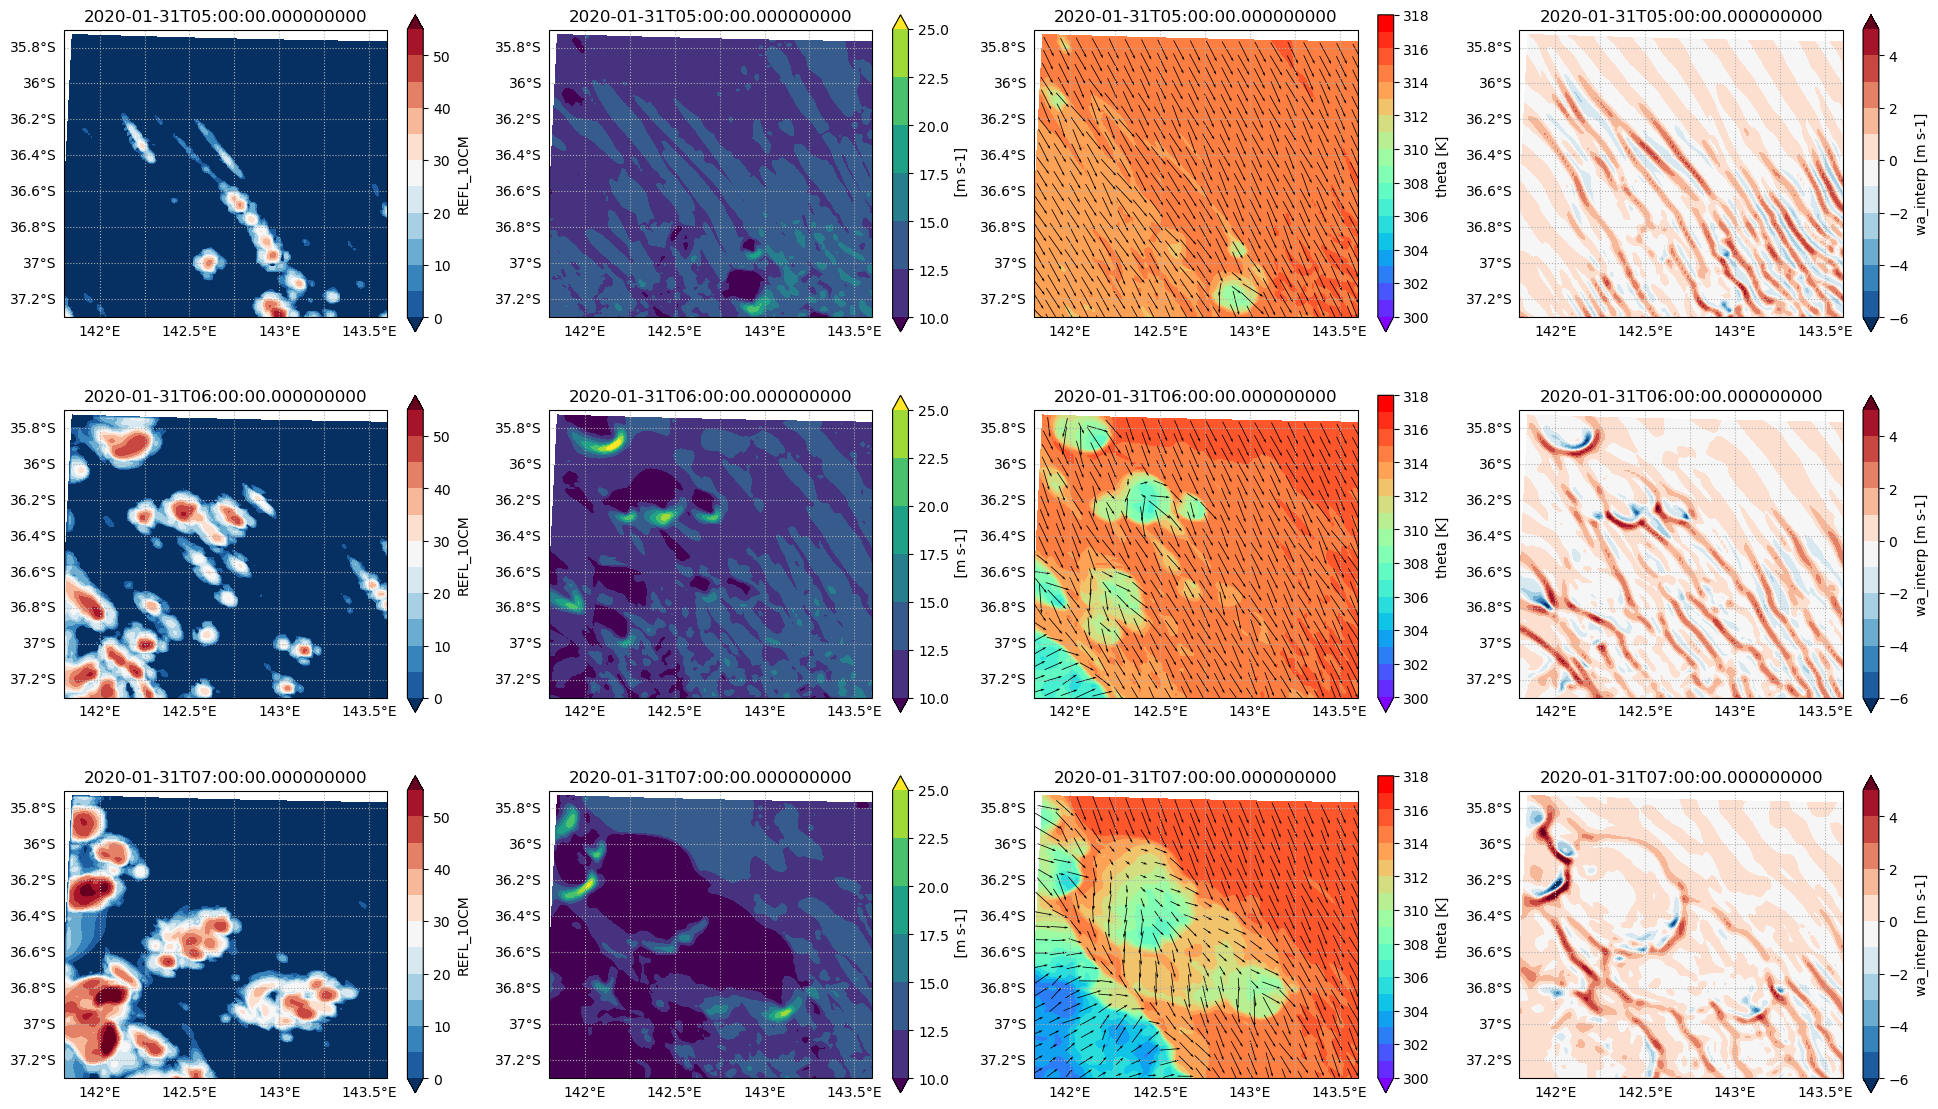

In [10]:
#Now, just for WRF, zoom in on a region, and plot the same fields (plus vertical velocity and theta)

plt.figure(figsize=[24,14])

rows=3;cols=4
t0=17

xlim = [141.8, 143.6]
ylim = [-37.3, -35.7]

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+4,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plot(wrflist,"W",t0+cnt,ax,levels=np.arange(-6,6,1),lev=1500)#cmap=plt.get_cmap("Blues_r"))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+1,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plot(wrflist,"REFL_10CM",t0+cnt,ax,levels=np.arange(0,60,5))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False    
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+2,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)    
    plot(wrflist,"WS10",t0+cnt,ax,levels=np.arange(10,27.5,2.5))
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False    
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+3,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)    
    plot(wrflist,"THETA",t0+cnt,ax,levels=np.arange(300,319,1),cmap=plt.get_cmap("rainbow"))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    
    u=wrf.getvar(wrflist,"U10",timeidx=t0+cnt)
    v=wrf.getvar(wrflist,"V10",timeidx=t0+cnt)
    xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":6,"west_east":6},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)   
    plt.title(u.Time.values)
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/wrf_20200131_zoomed.png",box_inches="tight")

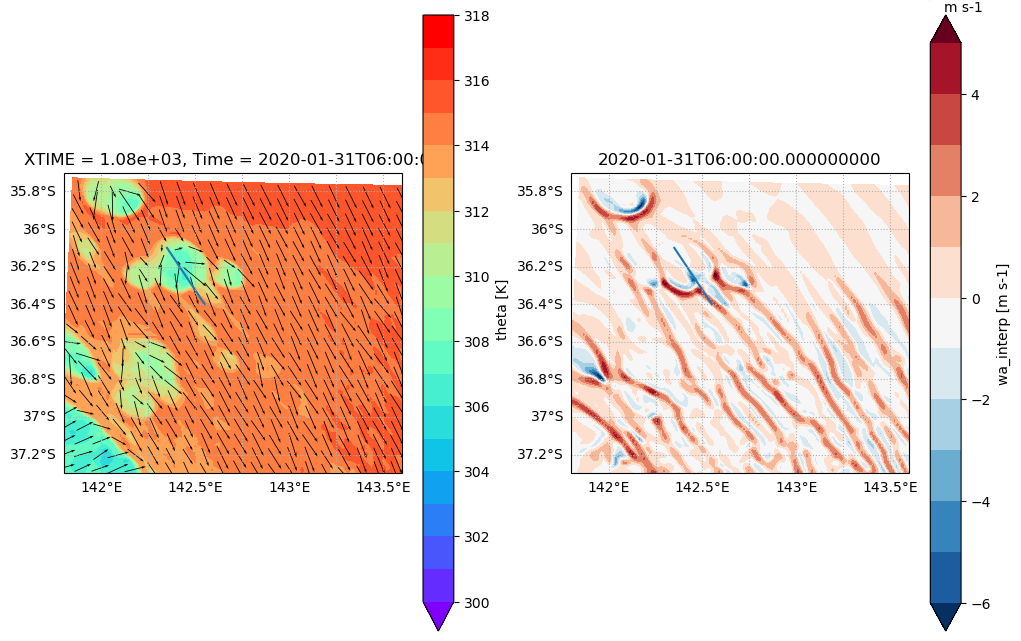

In [12]:
#Take a transect through one of these convective cells at time t_ind. Display the transects overlaid on theta/vertical velocity fields.

t_ind=18

xlim = [141.8, 143.6]
ylim = [-37.3, -35.7]
lats = [-36.1,-36.4]
lons = [142.35,142.55]

#PLOT THETA WITH TRANSECT
plt.figure(figsize=[12,8])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"THETA",t_ind,ax,levels=np.arange(300,319,1),cmap=plt.get_cmap("rainbow"))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False

u=wrf.getvar(wrflist,"U10",timeidx=t_ind)
v=wrf.getvar(wrflist,"V10",timeidx=t_ind)
xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":6,"west_east":6},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)  
ax.plot(lons, lats)

#PLOT W WITH TRANSECT
ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"W",t_ind,ax,lev=1500,levels=np.arange(-6,6,1))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
ax.plot(lons, lats)

(0.0, 10000.0)

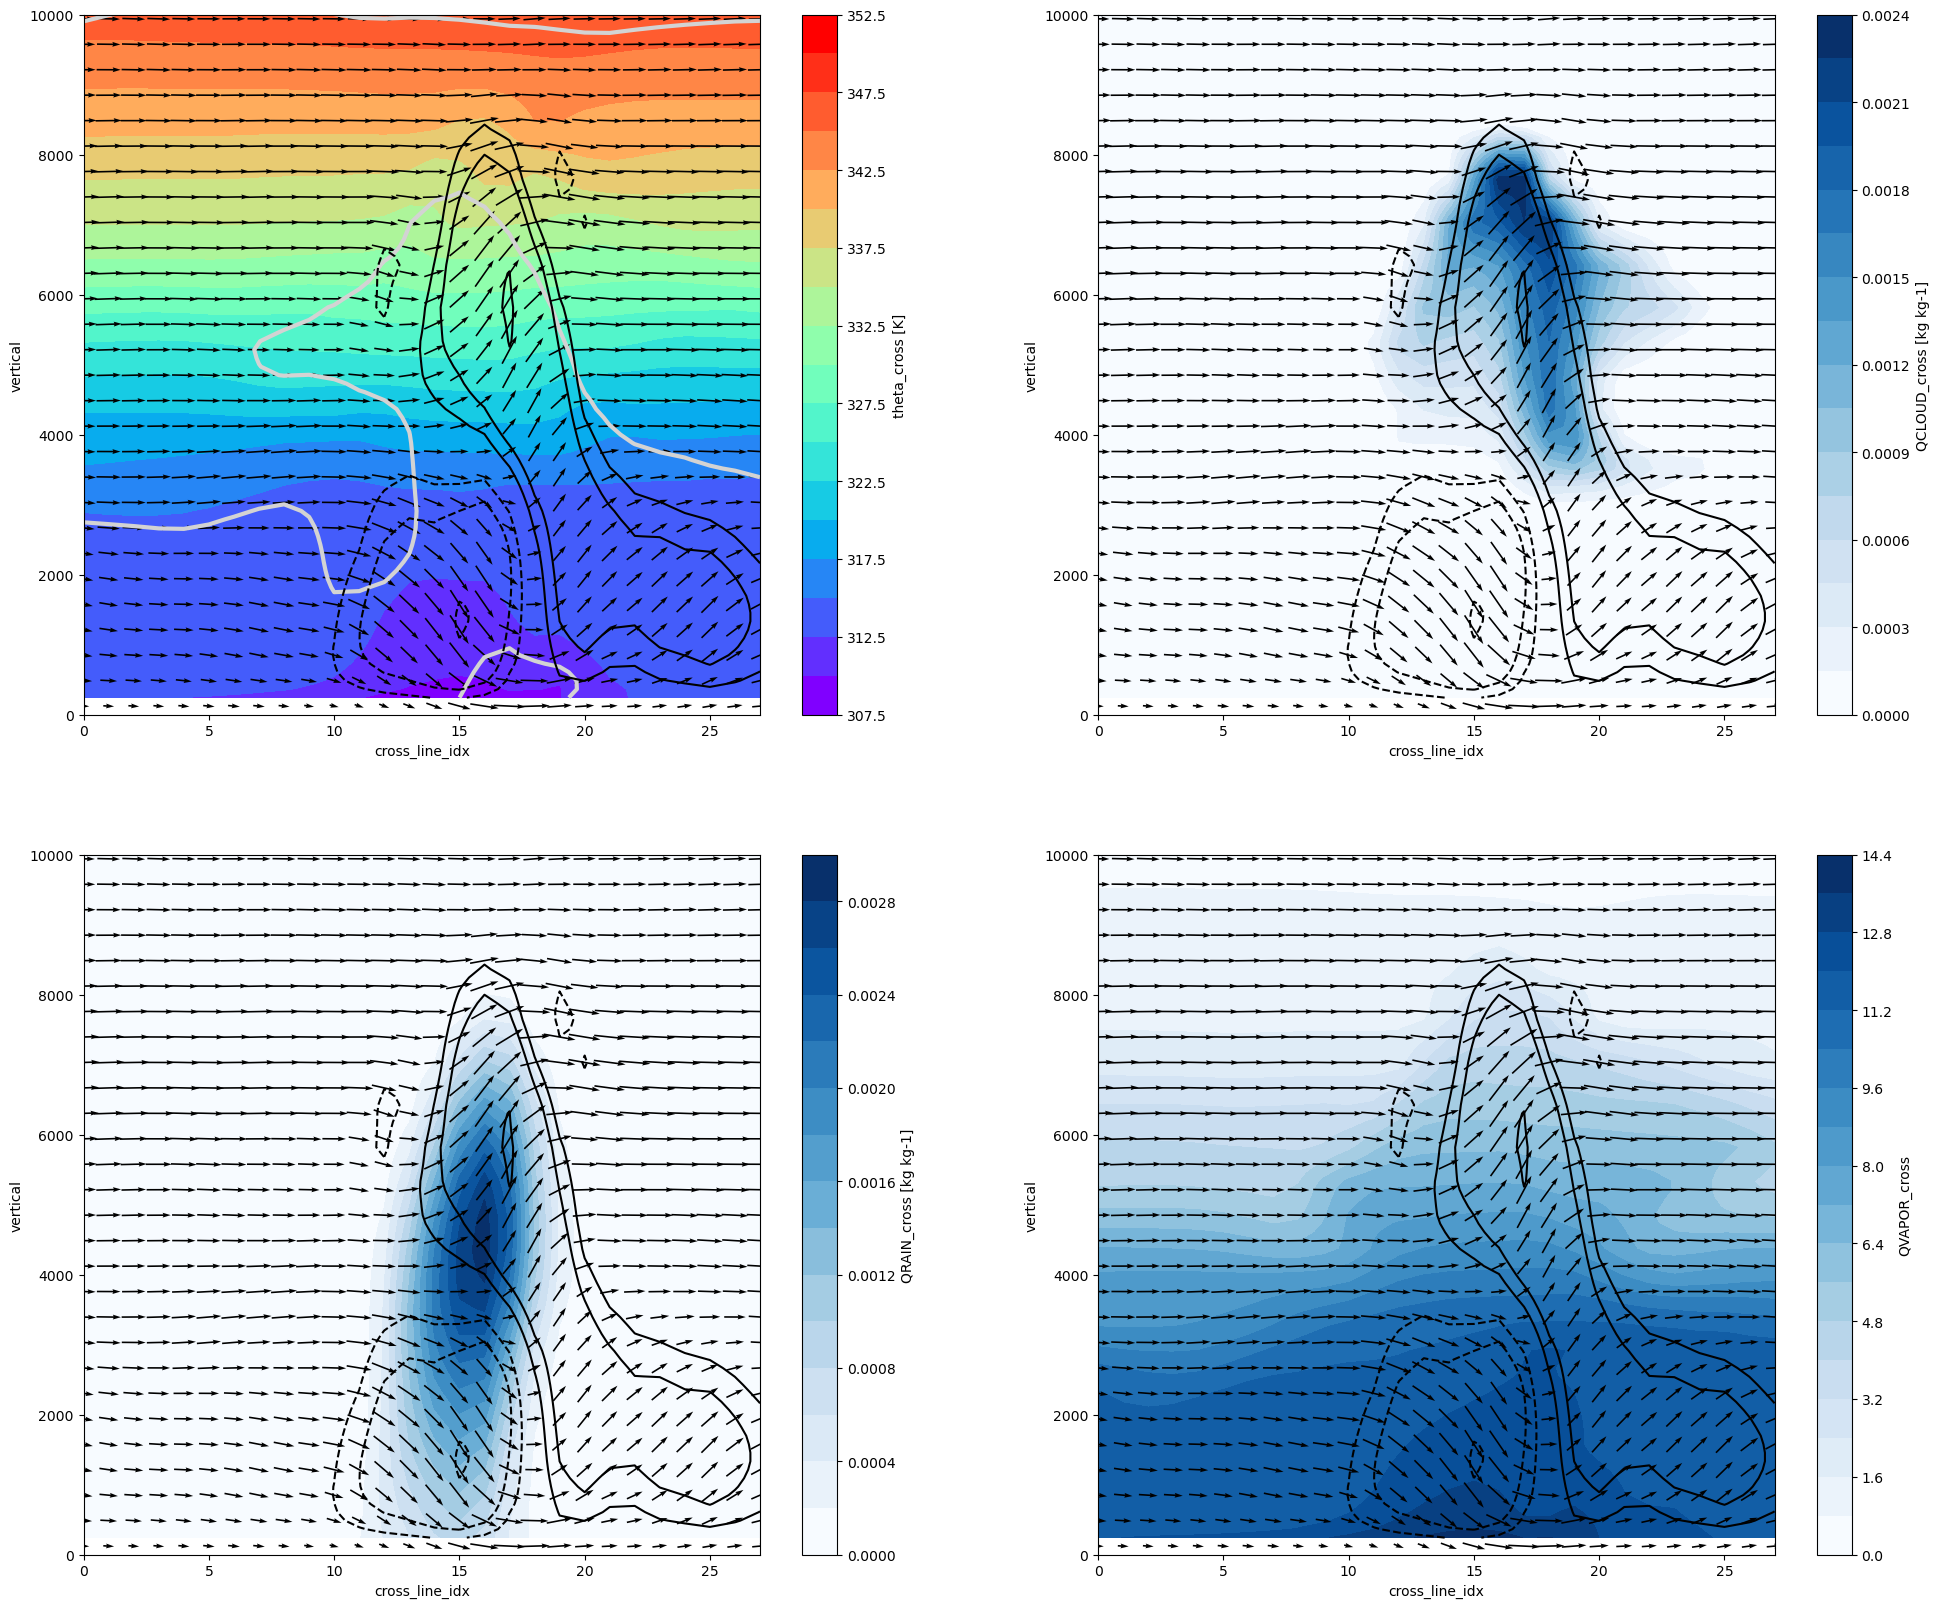

In [13]:
#Calculate transect-height data for various quantities, and plot
theta = wrf.getvar(wrflist,"theta",timeidx=t_ind)
heights = wrf.getvar(wrflist,"z",timeidx=t_ind)
P = wrf.getvar(wrflist,"P",timeidx=t_ind)
U = wrf.getvar(wrflist,"U",timeidx=t_ind)
V = wrf.getvar(wrflist,"V",timeidx=t_ind)
QR = wrf.getvar(wrflist,"QRAIN",timeidx=t_ind)
QC = wrf.getvar(wrflist,"QCLOUD",timeidx=t_ind)
QV = wrf.getvar(wrflist,"QVAPOR",timeidx=t_ind)
W = wrf.destagger(wrf.getvar(wrflist,"W",timeidx=t_ind),0,meta=True)

start_point = wrf.CoordPair(lat=lats[0],lon=lons[0])
end_point = wrf.CoordPair(lat=lats[1],lon=lons[1])
y1=lats[0]; y2=lats[1]
x1=lons[0]; x2=lons[1]
angle = np.arctan2((x2-x1),(y2-y1))

top=12000
theta_cross = wrf.vertcross(theta,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
p_cross = wrf.vertcross(P,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
u_cross = wrf.vertcross(U,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
v_cross = wrf.vertcross(V,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
w_cross = wrf.vertcross(W,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
qr_cross = wrf.vertcross(QR,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qv_cross = wrf.vertcross(QV,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qc_cross = wrf.vertcross(QC,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)

uu_cross = np.cos(angle) * u_cross - np.sin(angle) * v_cross
vv_cross = np.sin(angle) * u_cross + np.cos(angle) * v_cross

REFL = wrf.getvar(wrflist,"REFL_10CM",timeidx=t_ind)
refl_cross = wrf.vertcross(REFL,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)

plt.figure(figsize=[24,20])

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(vv_cross,levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

(0.0, 10000.0)

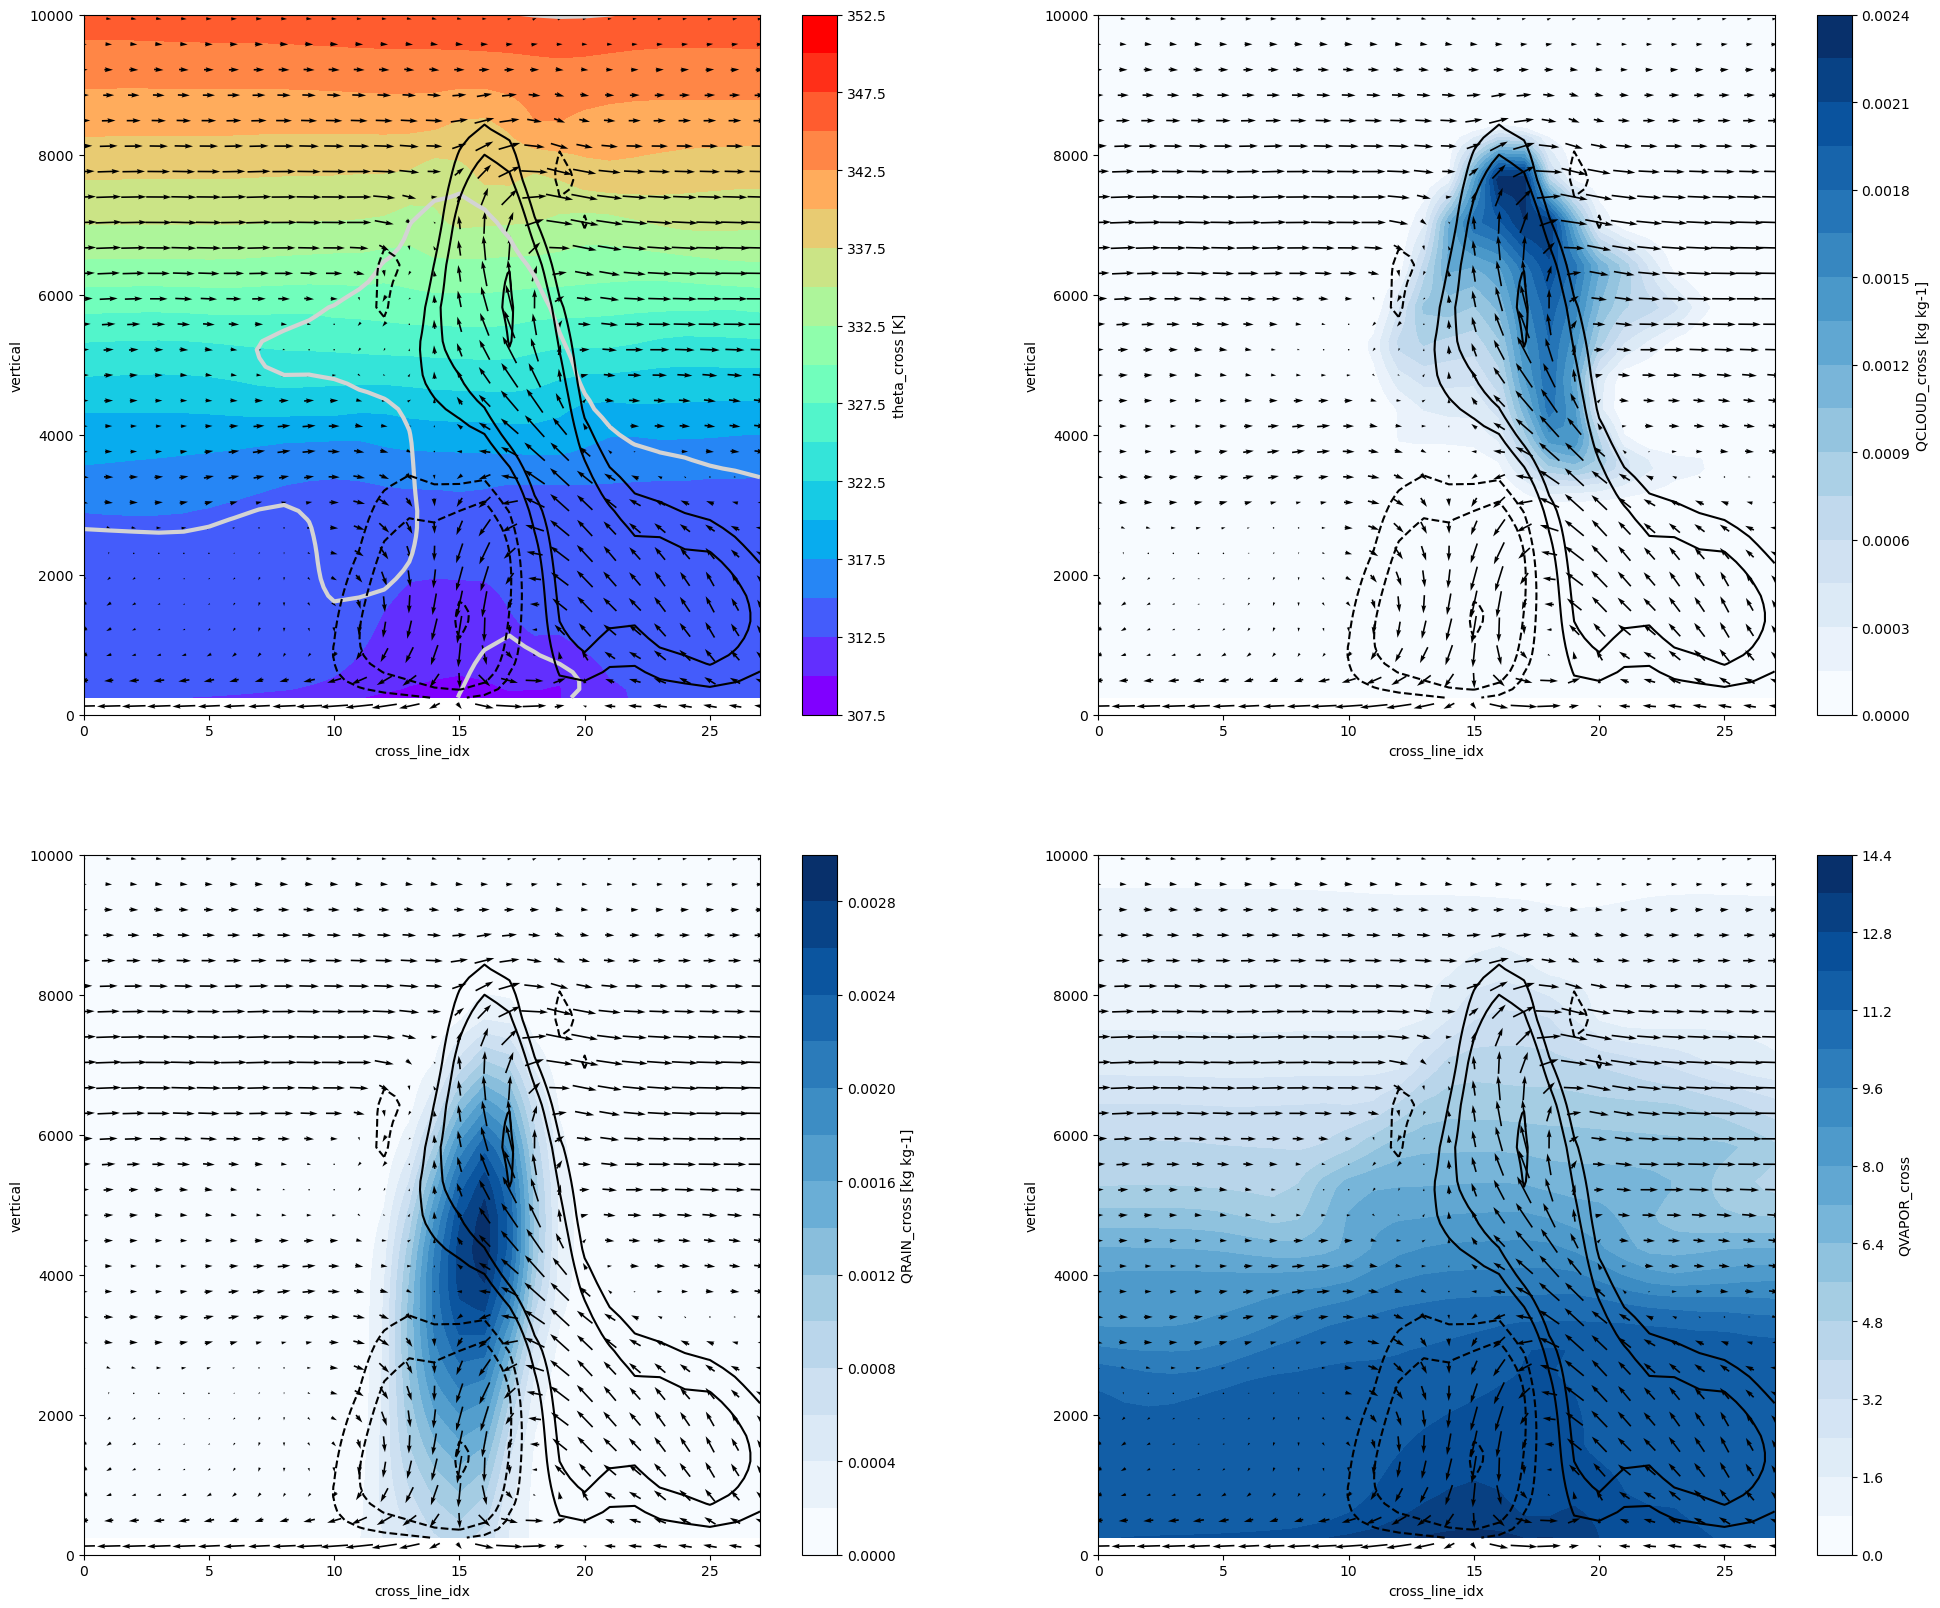

In [14]:
#Plot the same transects, but with storm-relative (using the 0-6 km mean) winds

plt.figure(figsize=[24,20])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*2}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean06 = wind_transect.sel({"vertical":slice(0,6000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean06

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

(0.0, 10000.0)

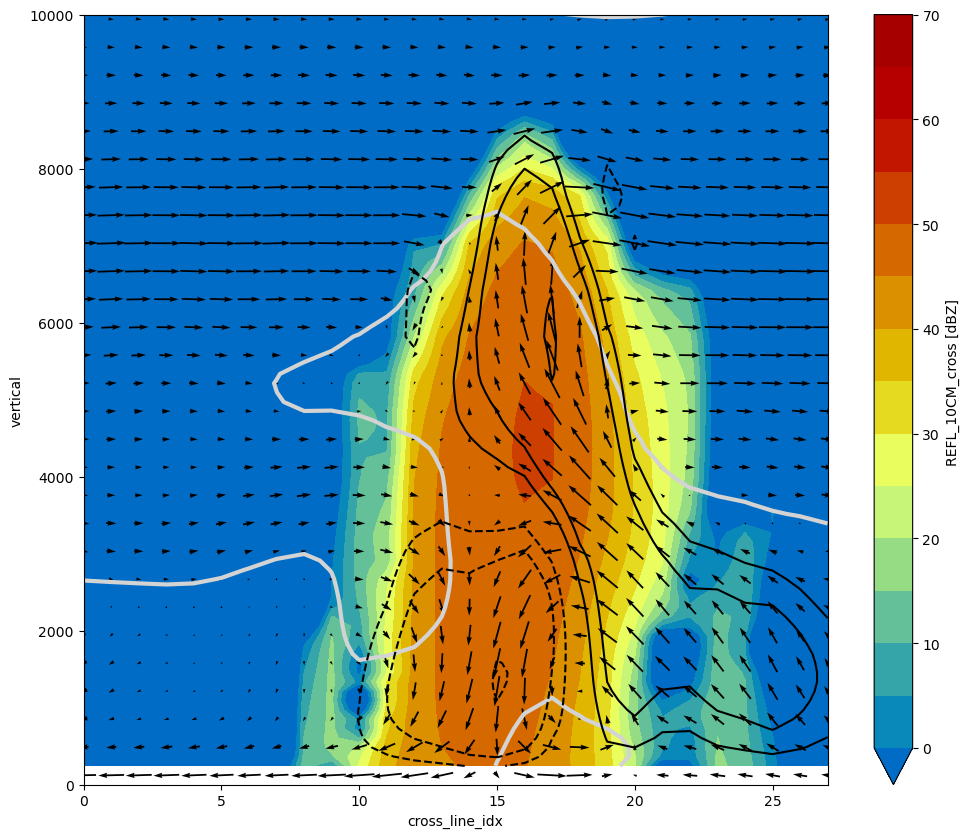

In [15]:
#Same plot but with model reflectivity

plt.figure(figsize=[12,10])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*2}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean06 = wind_transect.sel({"vertical":slice(0,6000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean06

xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,10000])

(0.0, 10000.0)

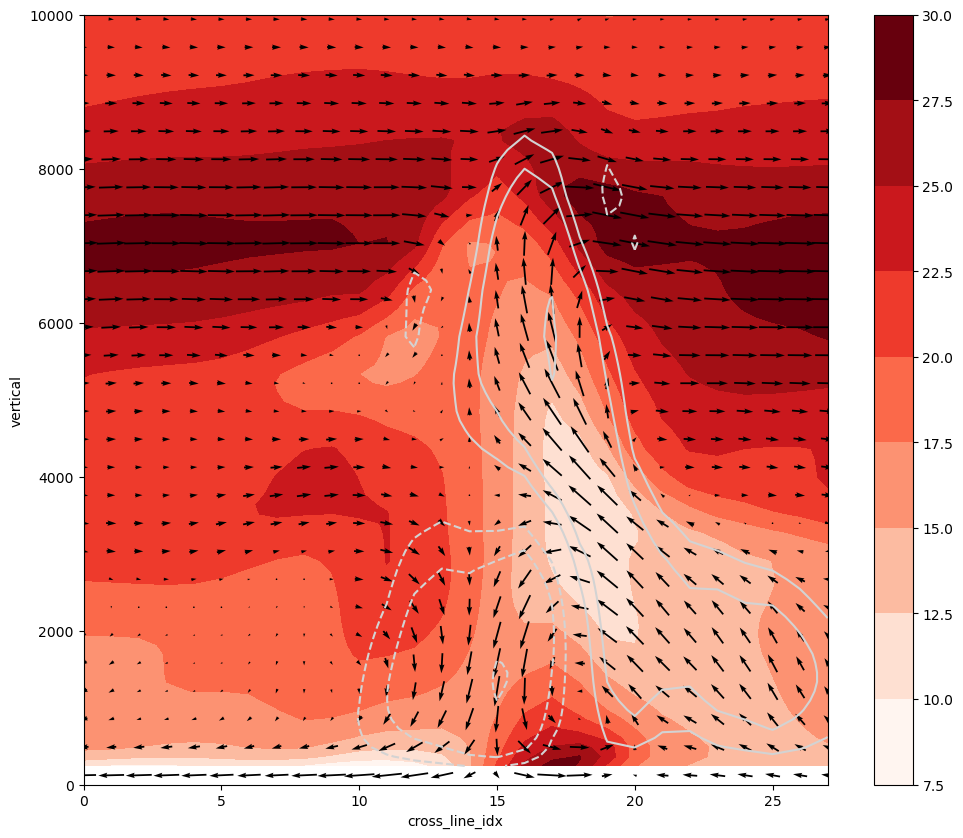

In [16]:
#Same plot but wind speed

plt.figure(figsize=[12,10])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*2}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean06 = wind_transect.sel({"vertical":slice(0,6000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean06

#xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
xr.plot.contourf(np.sqrt(((uu_cross**2) + (vv_cross**2))),cmap=plt.get_cmap("Reds"),levels=10)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="lightgray")
plt.ylim([0,10000])

(0.0, 10000.0)

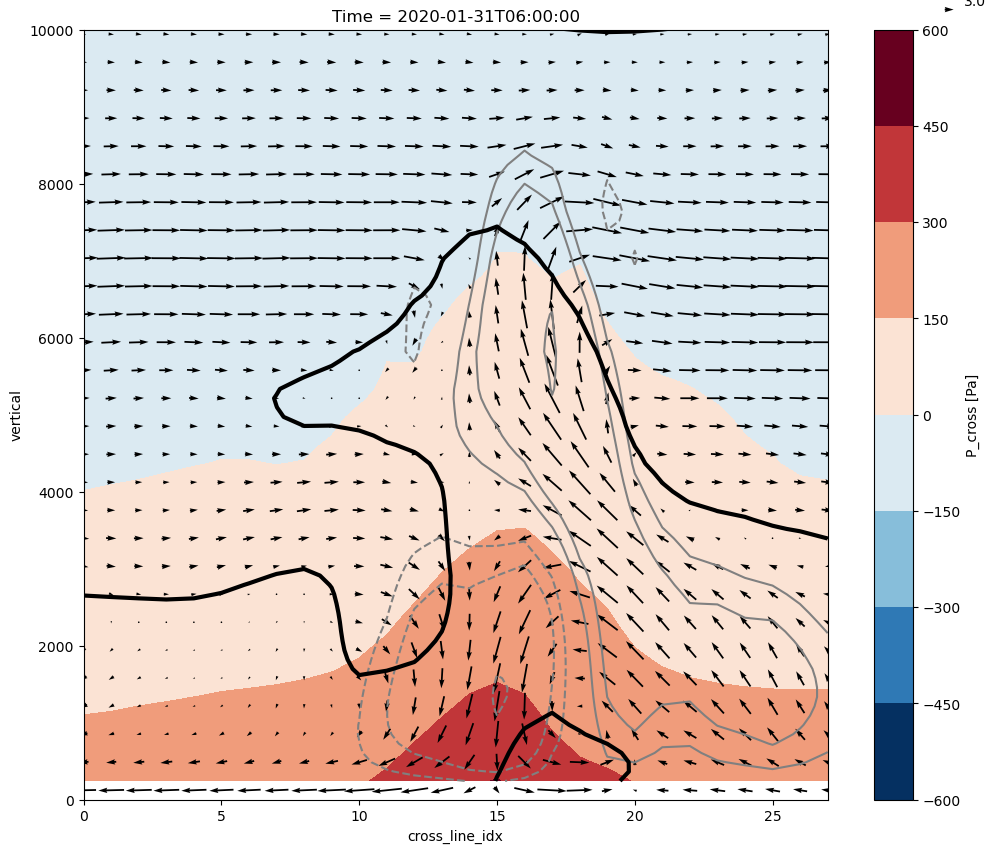

In [17]:
#Same plot but perturbation pressure

plt.figure(figsize=[12,10])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*2}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean06 = wind_transect.sel({"vertical":slice(0,6000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean06

#xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
xr.plot.contourf(p_cross,cmap=plt.get_cmap("RdBu_r"),levels=10)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="gray")
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="k",linewidths=3)
plt.ylim([0,10000])

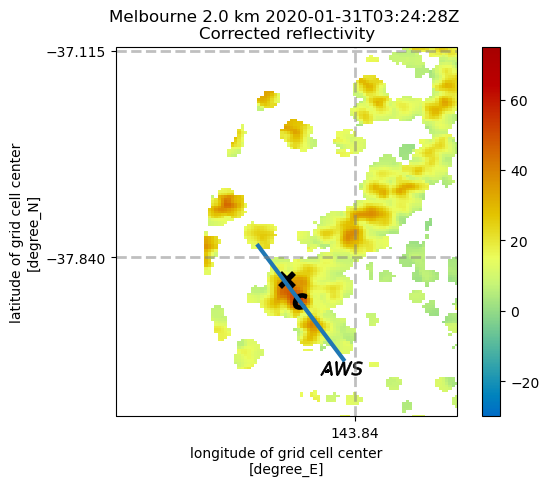

In [18]:
#Now, look at an observed cell, one that was responsible for the Cressy tower outages. Choose a transect, and plot it. This will be used to plot a height-transect image of reflectivity, to compare to the model

radar=load_radar("2",dt.datetime(2020,1,31,3,25))

ax=plt.axes(projection=ccrs.PlateCarree())
disp=pyart.graph.GridMapDisplay(radar)
disp.plot_grid("corrected_reflectivity",level=4, ax=ax)
ax.set_xlim([143,144.2])
ax.set_ylim([-38.4,-37.1])

ax.plot(143.644,-37.9931,marker="$c$",color="k",ms=10,mew=2)
ax.plot(143.79,-38.23,marker="$AWS$",color="k",ms=30,mew=0.5)
ax.plot(143.6,-37.92,marker="x",color="k",ms=10,mew=4)

ax.plot([143.5,143.8],[-37.8,-38.2],color="tab:blue",lw=3)

(1500.0, 11000.0)

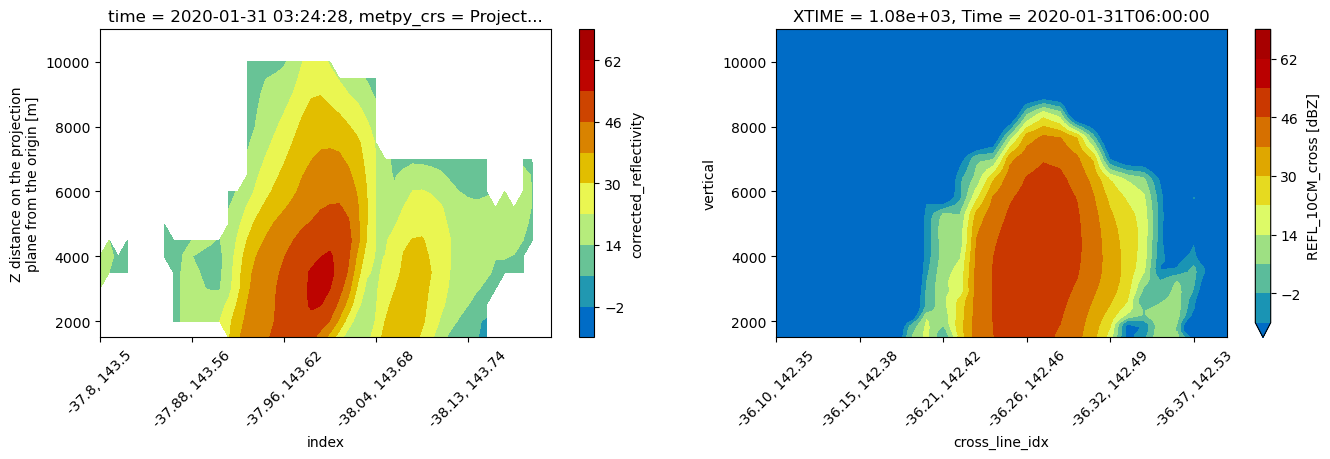

In [19]:
#Compare a cell transect from the observed radar reflectivity with the model reflectivity

def get_xlabs(cross):
    lon_str = cross.lon.values.round(2).astype(str)
    lat_str = cross.lat.values.round(2).astype(str)
    xlab = [i + ", " + j for i, j in zip(lat_str,lon_str)]
    return xlab

cross=cross_section(radar.to_xarray().isel({"time":0}).corrected_reflectivity.assign_coords(
    x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
    grid_mapping_name='latitude_longitude',
    earth_radius=6371229.0
),[-37.8,143.5],[-38.2,143.8],steps=50)

plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
xr.plot.contourf(cross,
    vmin=-10, 
    vmax=70,
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11)
plt.ylim([1500,11000])
plt.xticks(np.arange(0,50,10),get_xlabs(cross)[0::10])
plt.gca().tick_params(axis="x",rotation=45)

plt.subplot(1,2,2)
xr.plot.contourf(refl_cross.sel({"cross_line_idx":slice(0,40)}),
    vmin=-10, 
    vmax=70, 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11)
plt.xticks(np.arange(0,30,5),[refl_cross.sel({"cross_line_idx":slice(0,40)}).isel({"cross_line_idx":np.arange(0,30,5)}).xy_loc.values[i].latlon_str(fmt='{:.2f}, {:.2f}') for i in np.arange(len(np.arange(0,30,5)))])
plt.gca().tick_params(axis="x",rotation=45)
plt.ylim([1500,11000])